## Plotting the Hydordynamic Parameters for a Single Snaphot
The code below reads the .h5 files and plots density, pressure and x velocity as a function of position. These quantities are unitless.

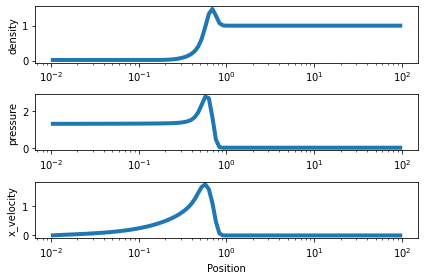

In [1]:
import numpy as np
import h5py
import pylab
import matplotlib.pyplot as plt

pylab.figure()
with h5py.File('output_1e3/final.h5', 'r') as f:
    for n, field in enumerate(['density', 'pressure', 'x_velocity']):
        pylab.subplot(3,1,n+1)
        pylab.semilogx(np.array(f['grid']),
                       np.array(f[field]),
                       linewidth=4)
        pylab.ylabel(field)
    pylab.xlabel('Position')
pylab.tight_layout()
pylab.savefig('Hydro_final.pdf')



## Tracking the Shock Front for Instantaneous Release of Energy
We find the shock front using a peakfinder, and chose 5 points around the peak to which we fit a parabola. We take the grid position of the peak of this parabola to be the position of the shock front. Once we have the position of the shock front at each timestep, we can fit a power law to the trajectory, finding the slope (which we expect to be 2/5) and prefactor.

In [2]:
from scipy.signal import find_peaks 
from scipy.optimize import curve_fit

def parabola(x, a, h, k):
    return a*(x-h)**2+k

def trajectory(t, a, b):
    return a*t**b

# shock trajectory
def get_shock_traj(N, folder):
    # N = number of snapshots
    shock_front = np.zeros(N)
    time = np.zeros(N)
    cut = 0
    for i in range(N):
        with h5py.File(folder+'/snapshot_%i.h5' % i, 'r') as f:
            P = np.array(f['pressure'])
            rho = np.array(f['density'])
            x_vel = np.array(f['x_velocity'])
            r = np.array(f['grid'])
            peak = find_peaks(x_vel)[0][-1] # the index of the peak
            #peak = find_peaks(P)[0][-1] # the index of the peak
            para_x = r[peak-3:peak+3] # fit a parabola around the peak
            para_y = x_vel[peak-3:peak+3]
            #para_y = P[peak-3:peak+3]
            try:
                fit_params, pcov = curve_fit(parabola, para_x, para_y, p0=[-50, r[peak], x_vel[peak]])
                #fit_params, pcov = curve_fit(parabola, para_x, para_y, p0=[-50, P[peak], x_vel[peak]])
                xs = np.linspace(min(para_x), max(para_x), 50)
                shock_front[i] = fit_params[1]
            except RuntimeError:    
                #shock_front[i] = r[find_peaks(x_vel)[0][-1]]
                shock_front[i] = r[find_peaks(P)[0][-1]]
            time[i] = np.array(f['time'])[0]
            # we want to ignore the points from the initial collapse
            if shock_front[i-1] > shock_front[i]:
                cut +=1
        # fit the trajectory to find the slope and prefator
    traj_params, traj_pcov = curve_fit(trajectory, time[cut:], shock_front[cut:], p0=[1., 0.4])
    print(traj_params[1], traj_pcov[1][1])
    return time, shock_front, traj_params, cut

time_1e2, shock_front_1e2, traj_params_1e2, cut_1e2 = get_shock_traj(100, "output_1e2")
time_5e2, shock_front_5e2, traj_params_5e2, cut_5e2 = get_shock_traj(100, "output_5e2")
time_1e3, shock_front_1e3, traj_params_1e3, cut_1e3 = get_shock_traj(100, "output_1e3")
time_5e3, shock_front_5e3, traj_params_5e3, cut_5e3 = get_shock_traj(100, "output_5e3")
time_1e4, shock_front_1e4, traj_params_1e4, cut_1e4 = get_shock_traj(100, "output_1e4")
time_5e4, shock_front_5e4, traj_params_5e4, cut_5e4 = get_shock_traj(100, "output_5e4")
time_1e5, shock_front_1e5, traj_params_1e5, cut_1e5 = get_shock_traj(100, "output_1e5")

0.4168757875086062 4.5932892717760697e-05
0.402918089042914 1.4378321001314265e-05
0.4035406721214654 7.214357620442342e-06
0.4013296837170576 1.2763049579398456e-06
0.402472693388974 2.4901070814923903e-06
0.3992037678210171 3.5531712161697334e-06
0.39985540236562894 2.71557707258005e-06
-0.00796220537934369 inf


/cita/modules/python/3.10.2/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [3]:
# the prefactors and energies of each trajectory
def energy(P):
    """The energy of the explosion, from the pressure within the hotspot."""
    rho = 1
    gamma = 5./3.
    return P/rho * 1/(gamma-1)

prefactors = np.array([traj_params_1e2[0], traj_params_5e2[0], traj_params_1e3[0], 
                       traj_params_5e3[0], traj_params_1e4[0], traj_params_5e4[0], traj_params_1e5[0]])
Es = np.array([energy(1e2), energy(5e2), energy(1e3), energy(5e3), energy(1e4), energy(5e4), energy(1e5)])

print(prefactors)
print(Es)

[0.9305248  1.2304969  1.4163686  1.94294107 2.23987538 3.06140724
 3.52400864]
[   150.    750.   1500.   7500.  15000.  75000. 150000.]


<IPython.core.display.Javascript object>


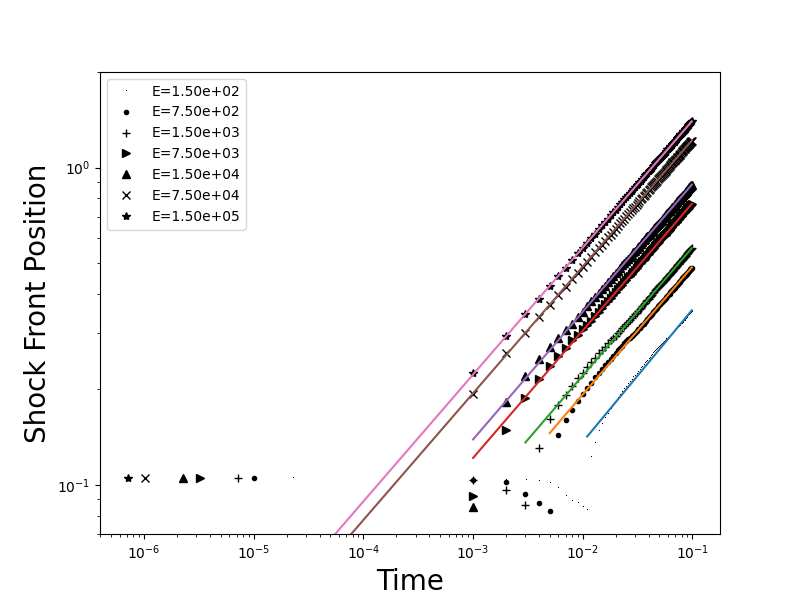

In [34]:
# plot the trajectory
ts_1e2 = np.linspace(min(time_1e2[cut_1e2:]), max(time_1e2), 100)
ts_5e2 = np.linspace(min(time_5e2[cut_5e2:]), max(time_5e2), 100)
ts_1e3 = np.linspace(min(time_1e3[cut_1e3:]), max(time_1e3), 100)
ts_5e3 = np.linspace(min(time_5e3[cut_5e3:]), max(time_5e3), 100)
ts_1e4 = np.linspace(min(time_1e4[cut_1e4:]), max(time_1e4), 100)
ts_5e4 = np.linspace(min(time_5e4[cut_5e4:]), max(time_5e4), 100)
ts_1e5 = np.linspace(min(time_1e5[cut_1e5:]), max(time_1e5), 100)

plt.figure(figsize=(8,6))
plt.plot(time_1e2, shock_front_1e2, 'k,', label='E=%1.2e'%energy(1e2))
plt.plot(ts_1e2, trajectory(ts_1e2, traj_params_1e2[0], traj_params_1e2[1]))

plt.plot(time_5e2, shock_front_5e2, 'k.', label='E=%1.2e'%energy(5e2))
plt.plot(ts_5e2, trajectory(ts_5e2, traj_params_5e2[0], traj_params_5e2[1]))

plt.plot(time_1e3, shock_front_1e3, 'k+', label='E=%1.2e'%energy(1e3))
plt.plot(ts_1e3, trajectory(ts_1e3, traj_params_1e3[0], traj_params_1e3[1]))

plt.plot(time_5e3, shock_front_5e3, 'k>', label='E=%1.2e'%energy(5e3))
plt.plot(ts_5e3, trajectory(ts_5e3, traj_params_5e3[0], traj_params_5e3[1]))

plt.plot(time_1e4, shock_front_1e4, 'k^', label='E=%1.2e'%energy(1e4))
plt.plot(ts_1e4, trajectory(ts_1e4, traj_params_1e4[0], traj_params_1e4[1]))

plt.plot(time_5e4, shock_front_5e4, 'kx', label='E=%1.2e'%energy(5e4))
plt.plot(ts_5e4, trajectory(ts_5e4, traj_params_5e4[0], traj_params_5e4[1]))

plt.plot(time_1e5, shock_front_1e5, 'k*', label='E=%1.2e'%energy(1e5))
plt.plot(ts_1e5, trajectory(ts_1e5, traj_params_1e5[0], traj_params_1e5[1]))

plt.xlabel('Time', fontsize=20)
plt.ylabel('Shock Front Position', fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.ylim([7e-2, 2])
plt.legend()
plt.savefig('Shock_Trajectory.pdf')
plt.show()

## Fitting the energy vs. prefactor
We fit a power law to this, where we expect the slopw to be 1/5.

In [5]:
# fitting the energy vs. prefactor
def prefactor(E, a, b):
    return a*E**b

fac_params, fac_pcov = curve_fit(prefactor,Es, prefactors, p0=[0.3, 0.2])
print(fac_params)

[0.33812047 0.19646963]


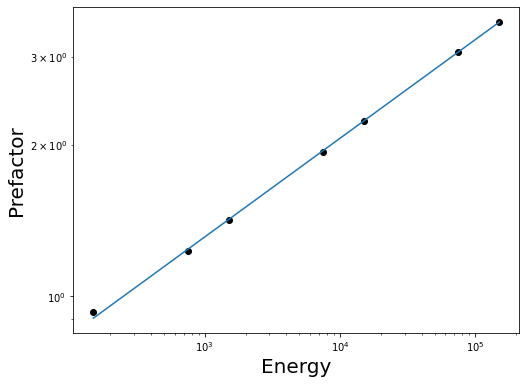

In [6]:
# plot the enrgy vs. prefactor
Ens = np.linspace(min(Es), max(Es), 100)

plt.figure(figsize=(8,6))
plt.plot(Es, prefactors, 'ko')
plt.plot(Ens, prefactor(Ens, fac_params[0], fac_params[1]))
plt.xlabel('Energy', fontsize=20)
plt.ylabel('Prefactor', fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.savefig('PreFac_vs_En.pdf')
plt.show()

## Energy Injection

In [49]:
def get_shock_traj_EnInj(N, path):
    # N = number of snapshots
    shock_front = np.zeros(N)
    time = np.zeros(N)
    cut = 1
    for i in range(N):
        with h5py.File(path+'/snapshot_%i.h5' % i, 'r') as f:
            P = np.array(f['pressure'])
            rho = np.array(f['density'])
            x_vel = np.array(f['x_velocity'])
            r = np.array(f['grid'])
            peak = find_peaks(rho)[0][-1] # the index of the peak
            #shock_front[i] = r[find_peaks(rho)[0][-1]]
            para_x = r[peak-3:peak+3] # fit a parabola around the peak
            para_y = rho[peak-3:peak+3]
            try:
                fit_params, pcov = curve_fit(parabola, para_x, para_y, p0=[-50, r[peak], rho[peak]])
                xs = np.linspace(min(para_x), max(para_x), 50)
                shock_front[i] = fit_params[1]
#                 plt.figure()
#                 plt.plot(para_x, para_y)
#                 plt.plot(xs, parabola(xs, fit_params[0], fit_params[1], fit_params[2]))
            except RuntimeError:    
                shock_front[i] = r[find_peaks(rho)[0][-1]]
            time[i] = np.array(f['time'])[0]
#             plt.figure()
#             plt.plot(r, rho)
#             plt.axvline(shock_front[i], color='black', linestyle='--')
#             plt.xscale('log')
            # we want to ignore the points from the initial collapse
            if np.log(shock_front[i-1]/shock_front[i])/np.log(time[i-1]/time[i]) < 0.3:
                cut +=1

    # fit the trajectory to find the slope and prefator
    traj_params, traj_pcov = curve_fit(trajectory, time[cut:], shock_front[cut:], p0=[1., 0.4])
    print(traj_params)
    return time, shock_front, traj_params, cut
    

In [50]:
time_EnInj_L1e2, shock_front_EnInj_L1e2, traj_params_EnInj_L1e2, cut_EnInj_L1e2 = get_shock_traj_EnInj(100, "output_EnInj_L1e2")
time_EnInj_L5e2, shock_front_EnInj_L5e2, traj_params_EnInj_L5e2, cut_EnInj_L5e2 = get_shock_traj_EnInj(100, "output_EnInj_L5e2")
time_EnInj_L1e3, shock_front_EnInj_L1e3, traj_params_EnInj_L1e3, cut_EnInj_L1e3 = get_shock_traj_EnInj(100, "output_EnInj_L1e3")
time_EnInj_L5e3, shock_front_EnInj_L5e3, traj_params_EnInj_L5e3, cut_EnInj_L5e3 = get_shock_traj_EnInj(100, "output_EnInj_L5e3")
time_EnInj_L1e4, shock_front_EnInj_L1e4, traj_params_EnInj_L1e4, cut_EnInj_L1e4 = get_shock_traj_EnInj(100, "output_EnInj_L1e4")
time_EnInj_L5e4, shock_front_EnInj_L5e4, traj_params_EnInj_L5e4, cut_EnInj_L5e4 = get_shock_traj_EnInj(100, "output_EnInj_L5e4")

/tmp/ipykernel_324691/178982760.py:31: RuntimeWarning: divide by zero encountered in log
  if np.log(shock_front[i-1]/shock_front[i])/np.log(time[i-1]/time[i]) < 0.3:
/tmp/ipykernel_324691/178982760.py:31: RuntimeWarning: invalid value encountered in double_scalars
  if np.log(shock_front[i-1]/shock_front[i])/np.log(time[i-1]/time[i]) < 0.3:


[2.3864415  0.59439701]
[3.32778069 0.59847566]
[3.82890765 0.59906557]
[5.35193258 0.60312918]
[6.44688283 0.61731213]
[11.62232072  0.69352255]


<IPython.core.display.Javascript object>


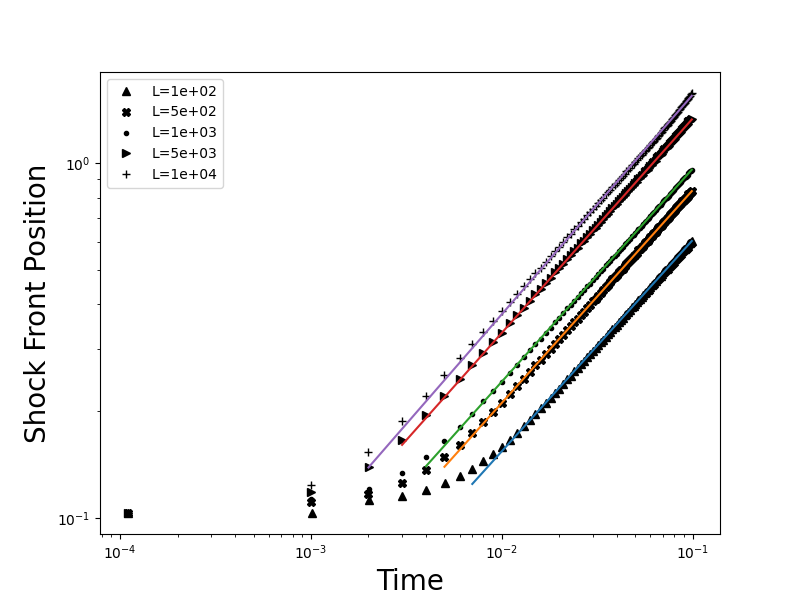

In [51]:
ts_EnInj_L1e2 = np.linspace(min(time_EnInj_L1e2[cut_EnInj_L1e2:]), max(time_EnInj_L1e2), 100)
ts_EnInj_L5e2 = np.linspace(min(time_EnInj_L5e2[cut_EnInj_L5e2:]), max(time_EnInj_L5e2), 100)
ts_EnInj_L1e3 = np.linspace(min(time_EnInj_L1e3[cut_EnInj_L1e3:]), max(time_EnInj_L1e3), 100)
ts_EnInj_L5e3 = np.linspace(min(time_EnInj_L5e3[cut_EnInj_L5e3:]), max(time_EnInj_L5e3), 100)
ts_EnInj_L1e4 = np.linspace(min(time_EnInj_L1e4[cut_EnInj_L1e4:]), max(time_EnInj_L1e4), 100)
ts_EnInj_L5e4 = np.linspace(min(time_EnInj_L5e4[cut_EnInj_L5e4:]), max(time_EnInj_L5e4), 100)

plt.figure(figsize=(8,6))
plt.plot(time_EnInj_L1e2, shock_front_EnInj_L1e2, 'k^', label='L=%1.0e'%1e2)
plt.plot(ts_EnInj_L1e2, trajectory(ts_EnInj_L1e2, traj_params_EnInj_L1e2[0], traj_params_EnInj_L1e2[1]))

plt.plot(time_EnInj_L5e2, shock_front_EnInj_L5e2, 'kX', label='L=%1.0e'%5e2)
plt.plot(ts_EnInj_L5e2, trajectory(ts_EnInj_L5e2, traj_params_EnInj_L5e2[0], traj_params_EnInj_L5e2[1]))

plt.plot(time_EnInj_L1e3, shock_front_EnInj_L1e3, 'k.', label='L=%1.0e'%1e3)
plt.plot(ts_EnInj_L1e3, trajectory(ts_EnInj_L1e3, traj_params_EnInj_L1e3[0], traj_params_EnInj_L1e3[1]))

plt.plot(time_EnInj_L5e3, shock_front_EnInj_L5e3, 'k>', label='L=%1.0e'%5e3)
plt.plot(ts_EnInj_L5e3, trajectory(ts_EnInj_L5e3, traj_params_EnInj_L5e3[0], traj_params_EnInj_L5e3[1]))

plt.plot(time_EnInj_L1e4, shock_front_EnInj_L1e4, 'k+', label='L=%1.0e'%1e4)
plt.plot(ts_EnInj_L1e4, trajectory(ts_EnInj_L1e4, traj_params_EnInj_L1e4[0], traj_params_EnInj_L1e4[1]))

# plt.plot(time_EnInj_L5e4, shock_front_EnInj_L5e4, 'k*', label='L=%1.0e'%5e4)
# plt.plot(ts_EnInj_L5e4, trajectory(ts_EnInj_L5e4, traj_params_EnInj_L5e4[0], traj_params_EnInj_L5e4[1]))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Shock Front Position', fontsize=20)
plt.legend()
plt.savefig('EnInj_Shock_Traj.pdf')
plt.show()

## Fitting the Luminosity vs. Prefactor
We fit a power law to this and again expect a slope of 1/5.

In [47]:
# L_prefactors = np.array([traj_params_EnInj_L1e2[0], traj_params_EnInj_L5e2[0], traj_params_EnInj_L1e3[0], 
#                        traj_params_EnInj_L5e3[0], traj_params_EnInj_L1e4[0], traj_params_EnInj_L5e4[0]])
# Ls = np.array([1e2, 5e2, 1e3, 5e3, 1e4, 5e4])

L_prefactors = np.array([traj_params_EnInj_L1e2[0], traj_params_EnInj_L5e2[0], traj_params_EnInj_L1e3[0], 
                       traj_params_EnInj_L5e3[0], traj_params_EnInj_L1e4[0]])
Ls = np.array([1e2, 5e2, 1e3, 5e3, 1e4])

L_fac_params, L_fac_pcov = curve_fit(prefactor, Ls, L_prefactors, p0=[0.3, 0.2])
print(L_fac_params)

[0.85490353 0.21769745]


<IPython.core.display.Javascript object>


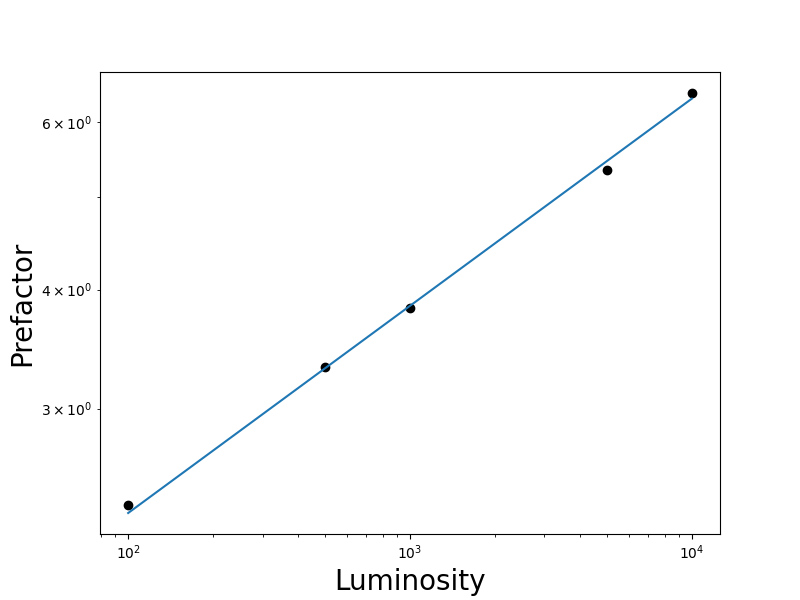

In [48]:
# plot the luminosity vs. prefactor
Lums = np.linspace(min(Ls), max(Ls), 100)

plt.figure(figsize=(8,6))
plt.plot(Ls, L_prefactors, 'ko')
plt.plot(Lums, prefactor(Lums, L_fac_params[0], L_fac_params[1]))
plt.xlabel('Luminosity', fontsize=20)
plt.ylabel('Prefactor', fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.savefig('PreFac_vs_Lum.pdf')
plt.show()

<IPython.core.display.Javascript object>


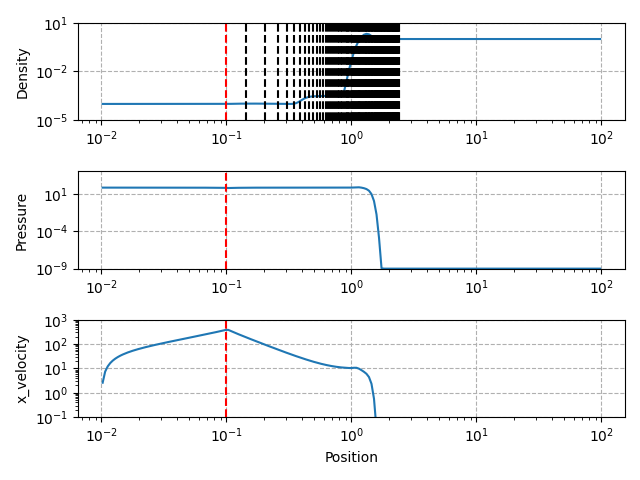

In [26]:
import matplotlib.animation as animation
edge=0.1
# animate the shock front
%matplotlib notebook

N = 100 # number of snapshots
shock_front2 = np.zeros(N)
time = np.zeros(N)

with h5py.File('output/snapshot_0.h5', 'r') as f:
    r = np.array(f['grid'])
    rho = np.array(f['density'])
    P = np.array(f['pressure'])
    x_vel = np.array(f['x_velocity'])
    

# initialize
plt.ion()
fig, ax = plt.subplots(3, 1)
x1, = ax[0].plot(r, rho)
x2, = ax[1].plot(r, P)
x3, = ax[2].plot(r, x_vel)

#x4, = ax[3].plot(shock_front, time, 'ko')

ax[0].set_ylabel('Density')
ax[0].set_ylim([1e-5,10])
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].axvline(edge, color='red', linestyle='--')
ax[0].grid(ls='--')

ax[1].set_ylabel('Pressure')
ax[1].set_ylim([1e-9,1e4])
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].axvline(edge, color='red', linestyle='--')
ax[1].grid(ls='--')

ax[2].set_ylabel('x_velocity')
ax[2].set_xlabel('Position')
ax[2].set_ylim([1e-1,1e3])
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].axvline(edge, color='red', linestyle='--')
ax[2].grid(ls='--')
#plt.savefig("ss0.png")
# ax[3].set_ylabel('time')
# ax[3].set_xlabel('Shock Front')
# ax[3].set_ylim([0,0.1])
# ax[3].set_xlim([0.01, 100])
# ax[3].set_xscale('log')
# ax[3].grid(ls='--')

fig.canvas.draw()

figs = []


#update
for i in range(1,N):
    with h5py.File('output_EnInj_L5e3/snapshot_{:}.h5'.format(i), 'r') as f:
        P = np.array(f['pressure'])
        rho = np.array(f['density'])
        x_vel = np.array(f['x_velocity'])
        r = np.array(f['grid'])
        #shock_front2[i] = r[find_peaks(x_vel)[0][-1]]
    #ind = get_shock_ind(i)
    x1.set_ydata(rho)
    ax[0].axvline(shock_front_EnInj_L5e4[i], color='black', linestyle='--')
    x2.set_ydata(P)
    #ax[1].axvline(shock_front_EnInj_L1e3[i], color='black', linestyle='--')
    x3.set_ydata(x_vel)
    #ax[2].axvline(shock_front_EnInj_L1e3[i], color='black', linestyle='--')
    #ax[2].axvline(shock_front2[i], color='red', linestyle='--')
    #x4.set_ydata(shock_front)
    fig.canvas.draw()
    plt.tight_layout()
    plt.pause(0.001)


MovieWriter stderr:
ffmpeg: /usr/lib64/nvidia-340xx/libOpenCL.so.1: no version information available (required by /lib64/libavfilter.so.7)
ffmpeg: /usr/lib64/nvidia-340xx/libOpenCL.so.1: no version information available (required by /lib64/libavfilter.so.7)
ffmpeg: /usr/lib64/nvidia-340xx/libOpenCL.so.1: no version information available (required by /lib64/libavutil.so.56)
ffmpeg: /usr/lib64/nvidia-340xx/libOpenCL.so.1: no version information available (required by /lib64/libavutil.so.56)
ffmpeg: symbol lookup error: /lib64/libavutil.so.56: undefined symbol: clGetExtensionFunctionAddressForPlatform, version OPENCL_1.2



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '648x432', '-pix_fmt', 'rgba', '-r', '12', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'EnInj_L1e2_floor.mp4']' returned non-zero exit status 127.

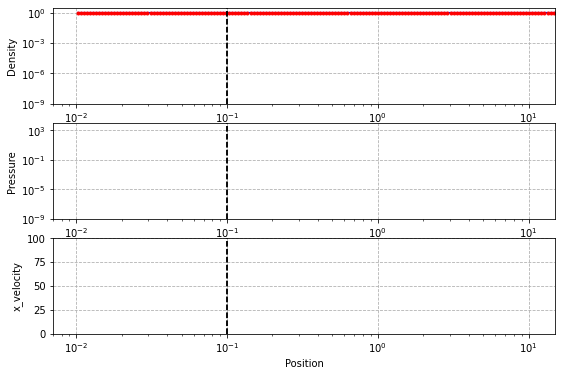

In [11]:
from matplotlib.animation import FuncAnimation
from matplotlib.artist import Artist
import matplotlib.animation as animation
import matplotlib.lines as lines

N = 100
edge = 0.1


fig = plt.figure(figsize=(9,6)) 
gs = fig.add_gridspec(3,1)
ax = gs.subplots()

ln1, = ax[0].plot([], [])
ln2, = ax[1].plot([], [])
ln3, = ax[2].plot([], [])
ln4, = ax[2].plot([], [])



def init():
    ax[0].set_ylabel('Density')
    ax[0].set_ylim([1e-9,3])
    ax[0].set_xlim([7e-3, 1.5e1])
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].axvline(edge, color='black', linestyle='--')
    ax[0].grid(ls='--')
    
    ax[1].set_ylabel('Pressure')
    ax[1].set_ylim([1e-9,1e4])
    ax[1].set_xlim([7e-3, 1.5e1])
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].axvline(edge, color='black', linestyle='--')
    ax[1].grid(ls='--')

    ax[2].set_ylabel('x_velocity')
    ax[2].set_xlabel('Position')
    ax[2].set_ylim([0,1e2])
    ax[2].set_xlim([7e-3, 1.5e1])
    ax[2].set_xscale('log')
    #ax[2].set_yscale('log')
    ax[2].axvline(edge, color='black', linestyle='--')
    ax[2].grid(ls='--')
    return ln1, ln2, ln3, ln4

def update(i):
    with h5py.File('output_EnInj_P1e0_L1e2_tf3.5e-2/snapshot_%i.h5' % i, 'r') as f:
        P = np.array(f['pressure'])
        rho = np.array(f['density'])
        x_vel = np.array(f['x_velocity'])
        r = np.array(f['grid'])
        p_ind = np.where(x_vel>0)
        n_ind = np.where(x_vel<0)            
        #x_vel[n_ind] = -x_vel[n_ind]
    
    ln1.set_data(r, rho)
    ln1.set_color("b")
    ln1.set_marker(".")
    ln1.set_mfc("r")
    ln1.set_mec("r")
    ax[0].axvline(shock_front_EnInj_L1e2[i])
    
    ln2.set_data(r, P)
    ln2.set_color("b")
    ln2.set_marker(".")
    ln2.set_mfc("r")
    ln2.set_mec("r")
    
    
    ln3.set_data(r, x_vel)
    ln3.set_color("b")
    ln3.set_marker(".")
    ln3.set_mfc("r")
    ln3.set_mec("r")
    
    ln4.set_data(r[n_ind], -x_vel[n_ind])
    ln4.set_color("r")
    ln4.set_marker(".")
    ln4.set_mfc("b")
    ln4.set_mec("b")
    plt.tight_layout()
    return ln1, ln2, ln3, ln4

ani = FuncAnimation(fig, update, frames=np.linspace(0, N, N),
                    init_func=init, blit=True)

mywriter = animation.FFMpegWriter(fps=12) 
ani.save('EnInj_L1e2_floor.mp4',writer=mywriter)

In [ ]:
def energies(i, g, K=False, T=False, tot=False):
    """Determines the kinetic, thermal and total energy interior to the schock front
    Can choose which of the energies you would like calculated
    - Calculates the kinetic energy with
    T = 1/2 * rho * v^2 * V
    where rho  is density, v is velocity, and V is volume
    - Calculates thermal energy is with 
    E_T = (P*V)/(g - 1)
    where P is pressure, V is volume, and g(gamma) is the adiabatic index
    
    Params:
        i (int): snapshot number
        g (float): adiabatic index -or- specific heat ratio
        K (bool): checks if kinetic energy should be calculated
        T (bool): checks if thermal energy should be calculated
        Tot (bool): checks if total energy should be calculated - K and T must also be True
    
    Returns:
        E_K (float or None): the kinetic energy
        E_T (float or None): the thermal energy
        E_tot (float or None): the total energy
    """
    E_K = None
    E_T = None
    E_tot = None
    with h5py.File('output/snapshot_%i.h5' % i, 'r') as f:
        #ind = get_shock_ind(i)
        rho = np.array(f['density'])#[:ind]
        v_x = np.array(f['x_velocity'])#[:ind]
        P = np.array(f["pressure"])#[:ind]
        r = np.array(f['grid'])#[:ind]
        n_ind = np.where(v_x<0)
        v_x[n_ind] = -v_x[n_ind]
        
    """
    THIS IS WITH SHELL APPROX
    -------------------------
    
    dr = np.zeros(len(r))
    r1 = r[2:]
    r2 = r[:-2]
    dr[1:-1] = (r1 - r2)/2
    dr[0] = (r[1] - r[0])/2 + r[0]
    dr[-1] = (r[-1] - r[-2])/2 
    V_s = 4*np.pi*r**2*dr  # the volume of each shell
    
    """
    """
    THIS IS WITH SPHERE VOLUME DIFFERENCE
    -------------------------------------
    """
    edges = np.zeros(len(r))
    R1 = r[1:]
    R2 = r[:-1]
    edges[:-1] = (R1 + R2)/2
    edges[-1] = r[-1]
    V_s = 4/3*np.pi*edges**3
    V1 = V_s[1:]
    V2 = V_s[:-1]
    V_s[:-1] = V1 - V2
    
    if K:
        E_Ks = 1/2*rho*v_x**2*V_s  # array of E_K for each shell
        E_K = np.sum(E_Ks)  # total kinetic energy
        
    if T: 
        E_Ts = P*V_s/(g - 1)  # array of E_T for each shell
        E_T = np.sum(E_Ts)  # total thermal energy
    
    if tot:
        try:
            E_tot = E_T + E_K
        except TypeError:
            print("Total energy can only be calculated if both K and T == True")
    
    return E_K, E_T, E_tot

Ek = np.zeros(100)
Eth = np.zeros(100)
Etot = np.zeros(100)
for i in range(100):
    Ek[i], Eth[i], Etot[i] = energies(i, 5/3, K=True, T=True, tot=True)     
print(Etot)